In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.decomposition import IncrementalPCA, KernelPCA, PCA
from   sklearn.linear_model import LogisticRegression
from   sklearn.manifold import LocallyLinearEmbedding as LLE
from   sklearn.metrics import mean_squared_error as mse
from   sklearn.model_selection import GridSearchCV
from   sklearn.pipeline import Pipeline

%matplotlib inline

### Make some highly-correlated data

In [2]:
n_cols = 50
n_rows = 500

X = pd.DataFrame(data=np.zeros([n_rows, n_cols]), 
                 columns=[f'x{i + 1}' for i in range(n_cols)])

In [3]:
X.x1 = np.random.uniform(size=n_rows)
for c in range(2, n_cols + 1):
    intercept = np.random.uniform(-10, 10, size=1)
    slope = np.random.uniform(-3, 3, 1)
    noise = np.random.normal(
        scale=np.random.uniform(0.01, np.abs(slope), n_rows))
    c2 = np.random.choice(range(1, c))
    X[f'x{c}'] = intercept + slope * X[f'x{c2}'] + noise

In [4]:
X.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50
0,0.816645,8.454015,-0.545023,7.981188,-7.117035,-7.347763,-12.012326,-22.583301,13.823841,-41.180153,...,4.277622,-35.015668,1.456630,-6.052178,-84.319207,-36.459157,291.392005,-31.208496,12.848542,9.964656
1,0.434301,9.355319,-0.044246,7.773932,-7.209484,-6.988225,-12.958119,-20.916872,15.472749,-44.673124,...,3.361459,-37.223217,-0.913944,-5.980090,-90.135155,-37.747203,318.913318,-31.009736,13.582008,11.159464
2,0.496046,8.023062,-0.167151,8.465247,-6.920041,-6.819159,-11.475435,-21.831217,12.908482,-38.009757,...,6.598625,-34.091976,-0.061563,-6.573382,-77.149453,-32.862149,269.825466,-34.289534,12.608070,5.425750
3,0.980487,6.990734,-0.152812,7.998346,-6.610046,-6.643653,-10.425224,-21.017948,9.376888,-29.076542,...,3.176190,-29.251957,0.157328,-6.833324,-72.021753,-30.220968,203.773686,-27.504921,10.952611,8.166603
4,0.653127,7.503660,-0.800962,8.179534,-6.915950,-7.926742,-12.117117,-21.425107,14.335516,-42.708795,...,2.276731,-34.886971,-0.092730,-5.741425,-88.543903,-37.927153,301.846078,-29.538144,13.160756,7.051499


In [5]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [6]:
# variance explained by each of the first 2 PCs
pca.explained_variance_ratio_ 

array([0.99041116, 0.00343077])

In [7]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

1

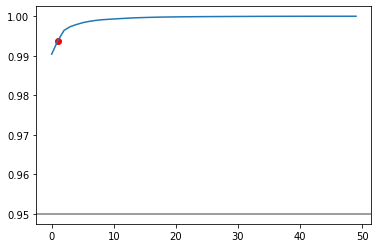

In [8]:
plt.plot(cumsum);
plt.axhline(0.95, c='k', alpha=0.5)
plt.scatter(d, cumsum[d], c='r');

In [9]:
pca = PCA(n_components=0.95)
X_red = pca.fit_transform(X)

In [10]:
X_red.shape

(500, 1)

In [11]:
X_recovered = pca.inverse_transform(X_red)
pd.DataFrame(X_recovered).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.482137,8.538346,-0.654328,8.224196,-7.029296,-7.220233,-12.057054,-21.395582,13.897636,-41.007483,...,3.675589,-34.528684,-0.369530,-6.263333,-84.904675,-35.768013,290.343720,-31.900905,12.936225,9.276913
1,0.456592,9.079312,-0.632455,8.222118,-7.168203,-7.195076,-12.766742,-21.344837,15.320754,-45.089449,...,3.665512,-36.688915,-0.446114,-6.269099,-91.126810,-38.137816,321.167625,-31.888774,13.613699,10.395043
2,0.498707,8.187452,-0.668516,8.225544,-6.939195,-7.236550,-11.596718,-21.428498,12.974537,-38.359735,...,3.682125,-33.127460,-0.319854,-6.259592,-80.868715,-34.230851,270.349937,-31.908774,12.496785,8.551642
3,0.558348,6.924489,-0.719582,8.230396,-6.614898,-7.295281,-9.939847,-21.546972,9.652059,-28.829786,...,3.705651,-28.084084,-0.141057,-6.246130,-66.342225,-28.698196,198.387003,-31.937095,10.915122,5.941202
4,0.472799,8.736100,-0.646332,8.223436,-7.080075,-7.211036,-12.316486,-21.377032,14.417866,-42.499674,...,3.671906,-35.318371,-0.397526,-6.265441,-87.179219,-36.634311,301.611609,-31.896470,13.183880,9.685653


In [12]:
# us. faster if m or n > ~500
rnd_pca = PCA(n_components=25, svd_solver='randomized') 
X_red = rnd_pca.fit_transform(X)

In [30]:
np.sqrt(mse(X, X_recovered))

2.0579242771368547

### Incremental PCA

In [13]:
N_BATCHES = 5
inc_pca = IncrementalPCA(n_components=20)

for X_batch in np.array_split(X, N_BATCHES):
    inc_pca.partial_fit(X_batch)
    
X_reducesd = inc_pca.transform(X)

In [14]:
# Alternately
#X_mn = np.memmap(
#    filename, dtype='float32', mode='readonly', shape=(m, n))
#BATCH_SIZE = m // N_BATCHES
#inc_pca = IncrementalPCA(n_components=20, batch_size=BATCH_SIZE)
#inc_pca.fit(X_mn)

### Kernel PCA

In [15]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

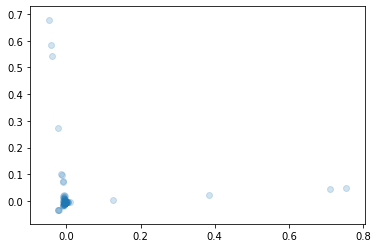

In [16]:
plt.scatter([x[0] for x in X_reduced], [x[1] for x in X_reduced], 
            alpha=0.2);

Selecting a Kernel and Tuning Parameters

In [18]:
clf = Pipeline([('kpca', KernelPCA(n_components=2)),
                ('log_reg', LogisticRegression())])
param_grid = [{'kpca__gamma': np.linspace(0.3, 0.5, 10),
               'kpca__kernel': ['rbf', 'sigmoid']}]
grid_search = GridSearchCV(clf, param_grid, cv=3)
#grid_search.fit(X, y)
#print(grid_search.best_params)

In [26]:
rbf_pca = KernelPCA(
    n_components=25, kernel='rbf', gamma=0.04, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [27]:
pd.DataFrame(X_preimage).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.509484,8.169922,-0.651788,8.089304,-6.864008,-7.112039,-11.566553,-21.109478,13.106676,-38.738890,...,3.718920,-33.100155,-0.181734,-6.224928,-80.854590,-34.220502,273.723175,-31.302588,12.458234,8.748572
1,0.493117,8.298474,-0.664464,8.225010,-6.967047,-7.229967,-11.739806,-21.418520,13.262153,-39.182337,...,3.682358,-33.564058,-0.336409,-6.259921,-82.121587,-34.709364,276.580014,-31.906907,12.633030,8.783146
2,0.489219,8.198632,-0.638024,8.153316,-6.891289,-7.157296,-11.606996,-21.203986,13.091977,-38.703704,...,3.764958,-33.150362,-0.355535,-6.180911,-80.919188,-34.199165,273.104645,-31.725640,12.487189,8.686692
3,0.493327,8.296567,-0.664560,8.225015,-6.966719,-7.229926,-11.737871,-21.418692,13.258189,-39.170787,...,3.682125,-33.557622,-0.335230,-6.260887,-82.101821,-34.701847,276.493437,-31.906687,12.631042,8.777336
4,0.490984,8.303774,-0.656269,8.207752,-6.959817,-7.223471,-11.752658,-21.381873,13.301101,-39.290738,...,3.660320,-33.600356,-0.321750,-6.241859,-82.249481,-34.747706,277.513474,-31.851563,12.642591,8.818360


In [29]:
np.sqrt(mse(X, X_preimage))

20.942225273328216

### Local Linear Embedding (LLE)

In [32]:
lle = LLE(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)